In [1]:
import pandas as pd
import pyodbc
import re
import matplotlib.pyplot as plt

#### Initial Data + SQL Query
Date Range - default to last 1 month  
Accesss - Only show data related to projects that the user has access to  


In [20]:
# Connect to DB

server = '168.61.188.232,1456'
database = 'ProdSureVue'
username = ''
password = ''

In [6]:
# example user data
user_id =  8286 # Sylvia, Project Manager - logged in user (from ProdSPLAuth user table)

# example date range
start_date = pd.to_datetime('2021-08-13', format='%Y-%m-%d') 
end_date = pd.to_datetime('2021-09-13', format='%Y-%m-%d') #current date


In [55]:
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

project_id_query = ('SELECT     CAST(ProdSureVue.dbo.PreLogSamples.CollectFrom as datetime),'
                               ' ProdSureVue.dbo.PreLogSamples.Imported,'
                                'ProdSureVue.dbo.PreLogSamples.SampledBy, '
                               ' ProdSureVue.dbo.PreLogSamples.StationName, '
                               ' ProdSureVue.dbo.PreLogSamples.StationNo, '
                              '  ProdSureVue.dbo.PreLogSamples.SamplingPoint, '
                               ' ProdSureVue.dbo.SureChemSummary.Received, '
                               ' ProdSureVue.dbo.SureChemSummary.SampledDate,'
                               ' ProdSureVue.dbo.SureChemSummary.ReportDate, '
                              '  ProdSureVue.dbo.SureChemSummary.AnalysisDate, '
                               ' ProdSureVue.dbo.SureChemSummary.DaysToDropOff, '
                               ' ProdSureVue.dbo.SureChemSummary.TestStatus, '
                               ' ProdSureVue.dbo.SureChemSummary.SampleStatus '

                            ' FROM ProdSPLAuth.dbo.user_project INNER JOIN '
                            ' ProdSPLAuth.dbo.projects ON ProdSPLAuth.dbo.user_project.project_id = ProdSPLAuth.dbo.projects.id '
                             ' INNER JOIN ProdSureVue.dbo.SampleLocations ON ProdSPLAuth.dbo.projects.unique_key = ProdSureVue.dbo.SampleLocations.LCProjectID '
                            ' INNER JOIN ProdSureVue.dbo.PreLogSamples ON ProdSureVue.dbo.SampleLocations.SLID = ProdSureVue.dbo.PreLogSamples.SLID '
                            ' INNER JOIN ProdSureVue.dbo.SureChemSummary ON ProdSureVue.dbo.PreLogSamples.PreLogID = ProdSureVue.dbo.SureChemSummary.PreLogID '
                            f'WHERE        (ProdSPLAuth.dbo.user_project.user_id = {user_id})')
                    
project_id_table = pd.read_sql_query(project_id_query, cnxn)
project_id_table.rename({'Unnamed: 1': 'CollectFrom'}, inplace=True)





In [57]:
project_id_table.head()

,,Imported,SampledBy,StationName,StationNo,SamplingPoint,Received,SampledDate,ReportDate,AnalysisDate,DaysToDropOff,TestStatus,SampleStatus
0,2021-02-22 22:45:04.303,True,Vern Lund <vern.lund@williams.com>,FILLMORE FEE STATE 14-36D CRP,94834,None,2021-03-26,2021-03-22 15:44:00,2021-03-30,2021-03-26 10:18:51,4.0,C,C
1,2021-02-23 22:00:12.420,True,Vern Lund <vern.lund@williams.com>,CRESTON NOSE 7-2-18-92 CRP,94797,None,2021-03-26,2021-03-22 14:59:00,2021-03-30,2021-03-26 10:27:12,4.0,C,C
2,2021-02-22 22:14:44.990,True,Vern Lund <vern.lund@williams.com>,EAST ECHO SPRINGS 11-35-19-92 CRP,94619,None,2021-03-26,2021-03-22 15:14:00,2021-03-30,2021-03-26 10:50:37,4.0,C,C
3,2021-03-22 23:15:08.523,True,Josh Cozzens <joshua.cozzens@williams.com>,BARREL SPRINGS 22-3 CRP,94780,None,2021-03-26,2021-03-22 17:15:00,2021-03-30,2021-03-26 10:11:32,4.0,C,C
4,2021-03-22 18:09:53.570,True,Aaron Peterson <aaron.peterson@williams.com>,CHAIN LAKES I5 21 PAD CRP,25673A,None,2021-03-26,2021-03-22 12:09:00,2021-03-30,2021-03-26 10:02:50,4.0,C,C


In [2]:
#Saving the data so I can use it whenever-
#project_id_table.to_csv(r'feild_audit_data.csv')
#project_id_table = pd.read_csv(r'feild_audit_data.csv')


In [15]:
#filter data by date:
project_id_table['SampledDate']  = pd.to_datetime(project_id_table['SampledDate'], infer_datetime_format=True)
project_id_table['Received']  = pd.to_datetime(project_id_table['Received'], infer_datetime_format=True)
project_id_table_sampled = project_id_table[(project_id_table['SampledDate'] >= start_date) & (project_id_table['SampledDate'] <= end_date)]
project_id_table_received = project_id_table[(project_id_table['Received'] >= start_date) & (project_id_table['Received'] <= end_date)]


#### Field Audit Figure 1
![figure1](images/field_audit_tech_table.PNG)

In [19]:
# Average Drop off Time
stdev_dropoff = round(project_id_table_sampled['DaysToDropOff'].std(), 1)
project_id_table_sampled[project_id_table_sampled['DaysToDropOff'] > (3 * stdev_dropoff) ]
avg_dropoff = round(project_id_table_sampled['DaysToDropOff'].mean(), 1)
print("Average Drop Off Time: ", avg_dropoff)

#Total Unaccounted For Samples
total_unaccounted_for_samples = project_id_table_sampled[project_id_table_sampled['DaysToDropOff'] > (3 * stdev_dropoff) ]['DaysToDropOff'].count()
print("Total Unaccounted For Samples: ", total_unaccounted_for_samples)


Average Drop Off Time:  4.0
Total Unaccounted For Samples:  221


In [20]:
# Table Of OverDue Samples
overdue_table =  project_id_table_sampled[project_id_table_sampled['DaysToDropOff'] > (3 * stdev_dropoff) ].sort_values(by=['DaysToDropOff'], ascending=False)
overdue_table = overdue_table[['StationName', 'StationNo', 'DaysToDropOff', 'SampledBy']]
overdue_table['SampledBy'] = overdue_table['SampledBy'].map(lambda x: re.sub('<.*?>', "", x))
overdue_table.rename(columns={'StationName': 'Location Name', 'StationNo': 'Meter Number', 'DaysToDropOff': '# Days', 'SampledBy': 'Tech Name'}, inplace=True)
print("Unaccounted For Samples Table")
overdue_table.head(10)


Unaccounted For Samples Table


,Location Name,Meter Number,# Days,Tech Name
17942,ST GATEWAY UNIT 731H,14029103,21.0,Bryan Salazar
17925,ST GATEWAY UNIT 733H,14029105,21.0,Bryan Salazar
17910,ST JOHNNY CASH UNIT 731H,14209101,20.0,Bryan Salazar
18352,WHISKEY BUTTES UNIT 222-24E WH REC,97753,20.0,Ron Brunski
18350,CHAMPLIN 288 E4 WH REC,91949,20.0,Ron Brunski
18109,QUAIL 2 SC MEOP,77699384,20.0,Tony Wright
18099,Quail 2 SC FC,77699371,20.0,Tony Wright
18096,Stella Blue 30 Fed Com Ctb Fc,77408351,20.0,Tony Wright
18087,STELLA BLUE 30 FED COM CTB MEOP,77408384,20.0,Tony Wright
17930,ST JOHNNY CASH CTB CK TO ZENA,14209172,20.0,Bryan Salazar


#### Field Audit Figure 2
![line_graph](images/field_audit_line_graph.PNG)

##### Note the x-axis is not correct in the graph  
##### Also, it isn't the average of the samples taken - it is just total samples taken and dropped off - That should be dropped from the title
##### We should have something that allows users to group the x axis by days, weeks, or months

In [21]:
SampleDate_day_group = project_id_table_sampled.groupby(pd.Grouper(key='SampledDate', freq="D"))['SampledDate'].count()
Received_day_group = project_id_table_received.groupby(pd.Grouper(key='Received', freq="D"))['Received'].count()
SampleDate_week_group = project_id_table_sampled.groupby(pd.Grouper(key='SampledDate', freq="W"))['SampledDate'].count()
Received_week_group = project_id_table_received.groupby(pd.Grouper(key='Received', freq="W"))['Received'].count()

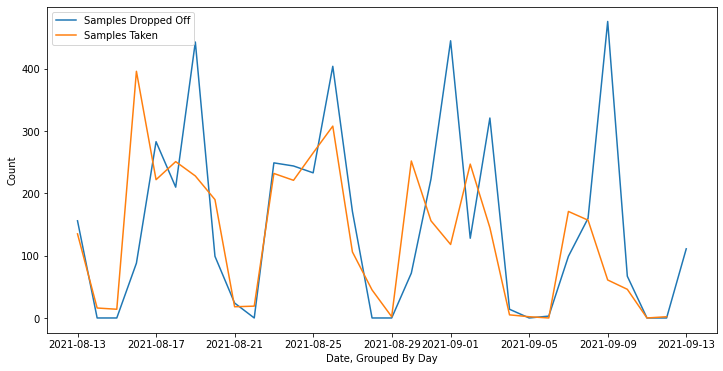

In [22]:
#Grouped By Day
fig = plt.figure(figsize=(12, 6))
plt.plot(Received_day_group.index, Received_day_group.values, label="Samples Dropped Off")
plt.plot(SampleDate_day_group.index, SampleDate_day_group.values, label="Samples Taken")
plt.xlabel('Date, Grouped By Day')
plt.ylabel('Count')
plt.legend()

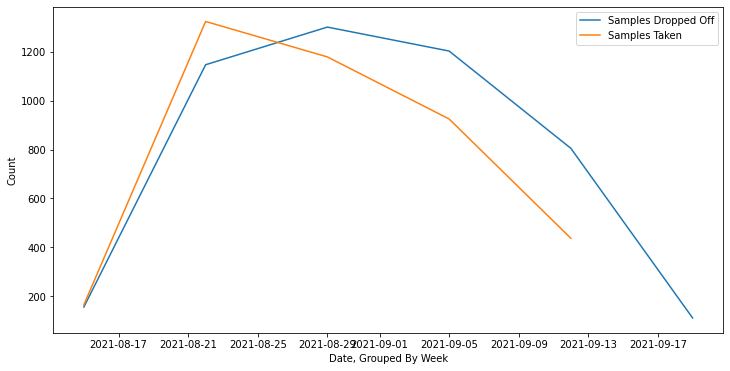

In [23]:
#Grouped By Week
fig = plt.figure(figsize=(12, 6))
plt.plot(Received_week_group.index, Received_week_group.values, label="Samples Dropped Off")
plt.plot(SampleDate_week_group.index, SampleDate_week_group.values, label="Samples Taken")
plt.xlabel('Date, Grouped By Week')
plt.ylabel('Count')
plt.legend()